# Construction of double-sorted risk factor

This codes construct a double-sorted long-short portfolio on Small/Big and Green/Brown stocks. Data includes all stocks from major EU countries from 2017:M1 to 2024:M8. Stocks are identified by the International Securities Identification Number (ISIN).

## Data preparation and factor construction

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

data = pd.read_csv("../Data/Data_for_3F.csv", index_col=0)

print(data.head())

         date          isin   Returns    Mkt. Cap.     EScore
0  2017-01-03  BE0003470755  0.134168  3347.546522  83.541034
1  2017-01-04  BE0003470755 -0.535954  3309.485548  83.541034
2  2017-01-05  BE0003470755 -0.404131  3320.062332  83.541034
3  2017-01-09  BE0003470755 -0.407056  3227.084078  83.541034
4  2017-01-10  BE0003470755 -0.681199  3312.894307  83.541034


## Construct Size factor

At each date $t$ we divide the stocks into five bins for each characteristic (Environmental Score and Size). The double-sorted long-short portfolio is defined as:
$$
\text{GMB}
= \tfrac{1}{2}\bigl(R_{G/S} + R_{G/B}\bigr)
- \tfrac{1}{2}\bigl(R_{B/S} + R_{B/B}\bigr)
$$

where:
- $R_{G/S}$: return of green and small stocks
- $R_{G/B}$: return of green and big stocks
- $R_{B/S}$: return of brown and small stocks
- $R_{B/B}$: return of brown and big stocks

Notice that this definition of the factor is consistent with the Fama-French factors. In fact, this is a size-neutral long-short portfolio on stocks' grenness

In [22]:
dates = data['date'].unique()

rBS = []
rGS = []
rBB = []
rGB = []
for t in dates:
    # Copy data at time t
    data_t = data[data['date'] == t].copy()
    
    # Construct five bins for each characteristics 
    data_t.loc[:, 'qESG'] = pd.qcut(data_t['EScore'], q=5, labels=list(range(1, 6)))
    data_t.loc[:, 'qSize'] = pd.qcut(data_t['Mkt. Cap.'], q=5, labels=list(range(1, 6)))

    # Define value-weighted returns for stocks jointly "Brown" and "Small"
    BrownSmall = data_t[(data_t['qESG'] == 1) & (data_t['qSize'] == 1)]
    wBrownSmall = np.array(BrownSmall['Mkt. Cap.'] / BrownSmall['Mkt. Cap.'].sum())
    rBrownSmall = np.array(BrownSmall['Returns'])
    rBS.append(wBrownSmall.T @ rBrownSmall)
    
    # Define value-weighted returns for stocks jointly "Brown" and "Big"
    BrownBig = data_t[(data_t['qESG'] == 1) & (data_t['qSize'] == 5)]
    wBrownBig = np.array(BrownBig['Mkt. Cap.'] / BrownBig['Mkt. Cap.'].sum())
    rBrownBig = np.array(BrownBig['Returns'])
    rBB.append(wBrownBig.T @ rBrownBig)

    # Define value-weighted returns for stocks jointly "Big" and "Green"
    GreenBig = data_t[(data_t['qESG'] == 5) & (data_t['qSize'] == 5)]
    wGreenBig = np.array(GreenBig['Mkt. Cap.'] / GreenBig['Mkt. Cap.'].sum())
    rGreenBig = np.array(GreenBig['Returns'])
    rGB.append(wGreenBig.T @ rGreenBig)

    # Define value-weighted returns for stocks jointly "Small" and "Green"
    GreenSmall = data_t[(data_t['qESG'] == 5) & (data_t['qSize'] == 1)]
    wGreenSmall = np.array(GreenSmall['Mkt. Cap.'] / GreenSmall['Mkt. Cap.'].sum())
    rGreenSmall = np.array(GreenSmall['Returns'])
    rGS.append(wGreenSmall.T @ rGreenSmall)
    

## Construct factor

In [17]:

SizeFactor = pd.DataFrame(index=dates, columns=['GreenBig', 'BrownSmall'])
SizeFactor['GreenBig'] = rGB
SizeFactor['BrownSmall'] = rBS
SizeFactor['GreenSmall'] = rGS
SizeFactor['BrownBig'] = rBB
SizeFactor['GmB'] = (1/2 * (SizeFactor['GreenSmall'] + SizeFactor['GreenBig']) -
                     1/2 * (SizeFactor['BrownSmall'] + SizeFactor['BrownBig']))



## Plot cumulative returns

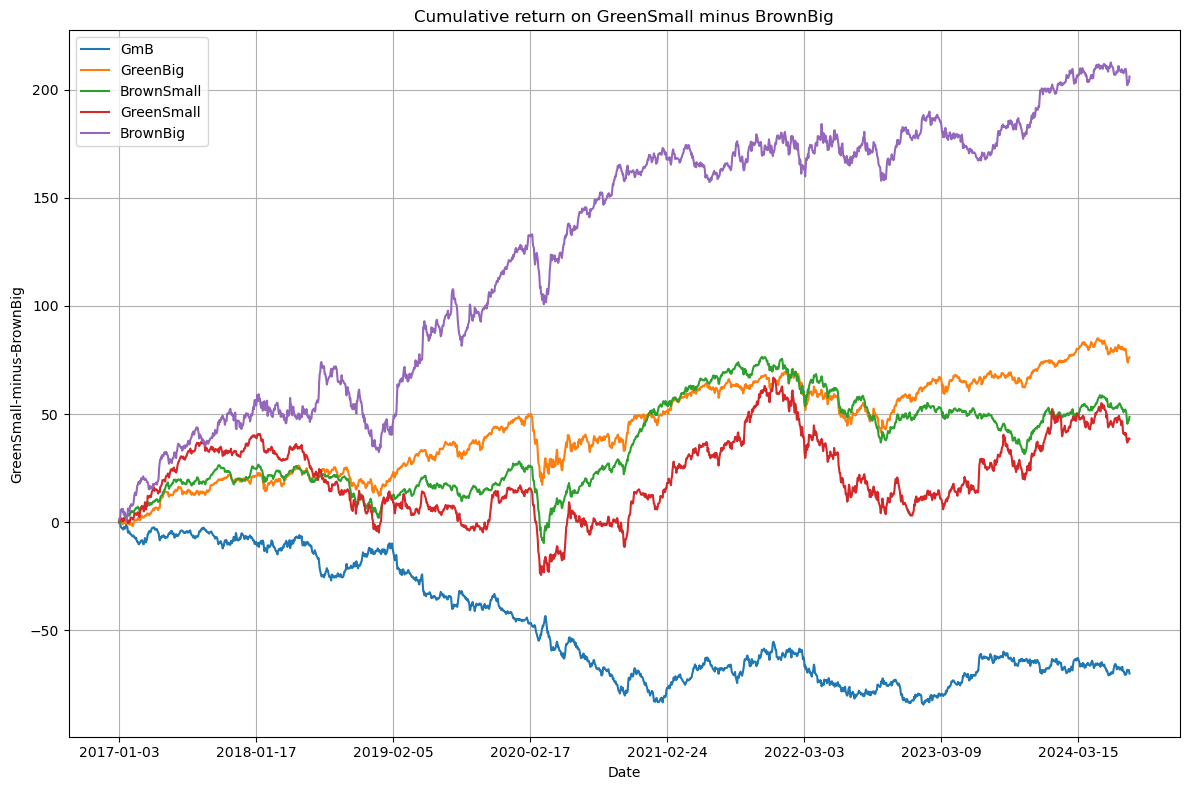

In [21]:
fig = plt.figure(figsize=(12, 8))
plt.plot(SizeFactor['GmB'].cumsum(), label='GmB')
plt.plot(SizeFactor['GreenBig'].cumsum(), label='GreenBig')
plt.plot(SizeFactor['BrownSmall'].cumsum(), label='BrownSmall')
plt.plot(SizeFactor['GreenSmall'].cumsum(), label='GreenSmall')
plt.plot(SizeFactor['BrownBig'].cumsum(), label='BrownBig')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("GreenSmall-minus-BrownBig")
plt.title("Cumulative return on GreenSmall minus BrownBig")
plt.legend()
plt.tight_layout()
plt.show()

## Construct a Size-adjusted Green-minus-Brown factor

The Green-minusBrown portfolio is not Size neutral and there could be a selection bias in the sample because companies with an ESG score are bigger stocks. Moreover, we are restricting the analisys to a short period where many geopolitical and economics events occurred:
- Sovereign Bond Crisis 
- Russian invasion of Ukraine
- Covid 19
- Inflation and in particular energy prices inflation

What we know is that Big and Brown firms (typically from Energy/Mining sectors) outperformed the other portfolios, but also Green and Big companies has cumulative returns larger than smaller stocks. 

Let's construct a Green-minus-Brown size-adjusted long-short portfolio:

$$
\text{GMB size adj.}
= \tfrac{1}{2}\bigl(R_{G/S} - R_{G/B}\bigr)
- \tfrac{1}{2}\bigl(R_{B/S} - R_{B/B}\bigr)
$$


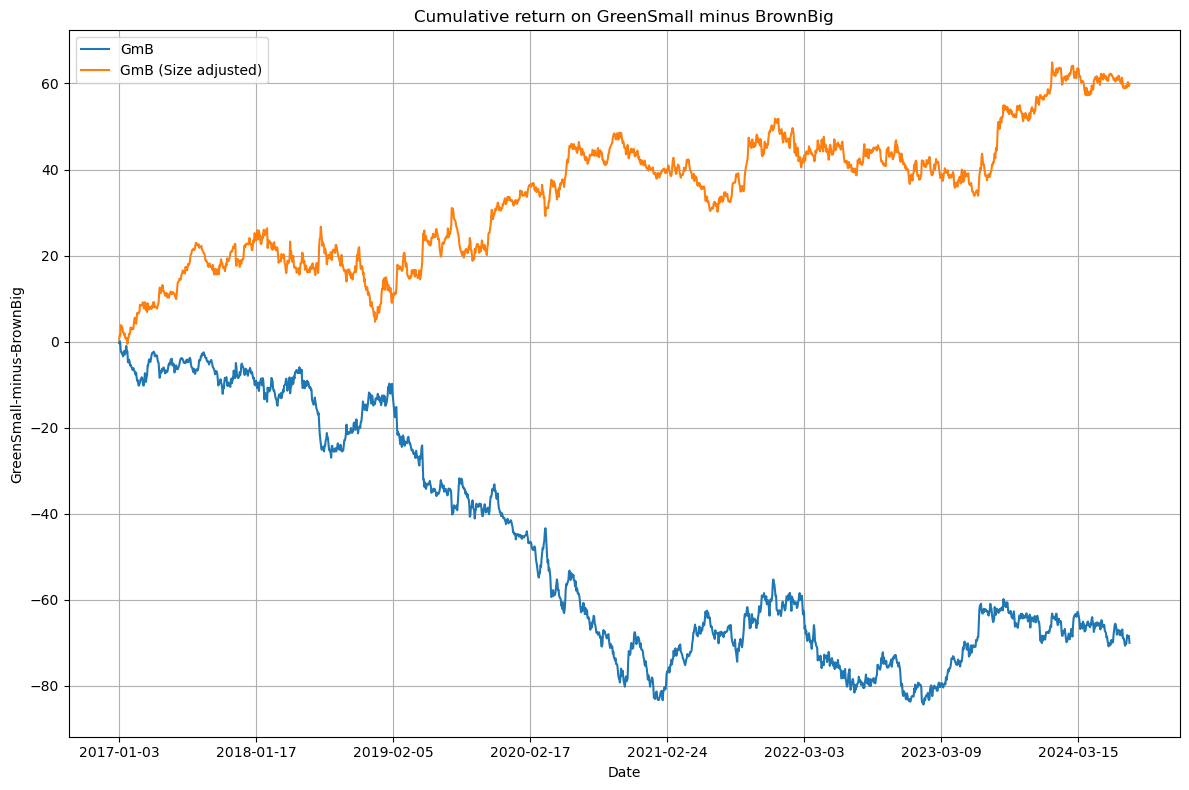

In [20]:
SizeFactor['GmB_sizeadj'] = (1/2 * (SizeFactor['GreenSmall'] - SizeFactor['GreenBig']) -
                     1/2 * (SizeFactor['BrownSmall'] - SizeFactor['BrownBig']))

fig = plt.figure(figsize=(12, 8))
plt.plot(SizeFactor['GmB'].cumsum(), label='GmB')
plt.plot(SizeFactor['GmB_sizeadj'].cumsum(), label='GmB (Size adjusted)')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("GreenSmall-minus-BrownBig")
plt.title("Cumulative return on GreenSmall minus BrownBig")
plt.legend()
plt.tight_layout()
plt.show()